In [1]:
using CSV
using DataFrames

In [ ]:
# Load the ratings data
path="data/ml-32m/"
ratings = CSV.read(path*"ratings.csv", DataFrame)


UndefVarError: UndefVarError: `countmap` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [5]:

# Count the number of ratings per user and per movie
user_counts = combine(groupby(ratings, :userId), nrow => :count)
movie_counts = combine(groupby(ratings, :movieId), nrow => :count)

Row,movieId,count
,Int64,Int64
1,1,68997
2,2,28904
3,3,13134
4,4,2806
5,5,13154
6,6,29490
7,7,13585
8,8,1510
9,9,4154


In [264]:
# Set thresholds
min_ratings_per_user = 1700
min_ratings_per_movie =10000

# Get active users and popular movies as Sets
active_users = Set(user_counts[user_counts.count .>= min_ratings_per_user, :userId])
popular_movies = Set(movie_counts[movie_counts.count .>= min_ratings_per_movie, :movieId])

# Create a dense subset using Sets for faster lookup
dense_ratings = filter(row -> row.userId in active_users && row.movieId in popular_movies, ratings)

Row,userId,movieId,rating,timestamp
,Int64,Int64,Float64,Int64
1,28,1,4.0,961438127
2,28,2,3.0,961594981
3,28,3,4.0,961439278
4,28,5,2.0,961437647
5,28,6,3.0,961515642
6,28,7,3.0,961439170
7,28,10,3.0,961515863
8,28,11,5.0,1052148205
9,28,16,3.0,961517557


In [ ]:
active_users
using Random

# Split active users into training and test sets
train_ratio = 0.8
num_train = Int(floor(train_ratio * length(active_users)))
train_users = Random.shuffle(collect(active_users))[1:num_train]
test_users = setdiff(active_users, train_users)

train_users
test_users

Set{Int64} with 191 elements:
  95987
  171703
  44021
  126678
  188777
  18699
  187073
  105475
  44117
  13241
  80462
  74000
  21170
  192924
  57457
  97973
  170502
  33911
  108412
  ⋮ 

In [269]:
num_users = length(unique(dense_ratings.userId))
num_movies = length(unique(dense_ratings.movieId))

println("Number of users: $num_users")
println("Number of movies: $num_movies")
fill_rate=100*nrow(dense_ratings)/num_users/num_movies
println("Fill rate: $fill_rate%")
#length(dense_ratings)


Number of users: 952
Number of movies: 772
Fill rate: 68.70305764792964%


In [273]:
train_users_arr

761-element Vector{Int64}:
  36287
 159663
 193248
  83924
 154324
  15364
  57346
  13171
  43386
 157795
      ⋮
 132558
  50978
 199004
  59335
  22270
 120635
 107510
  15968
 150869

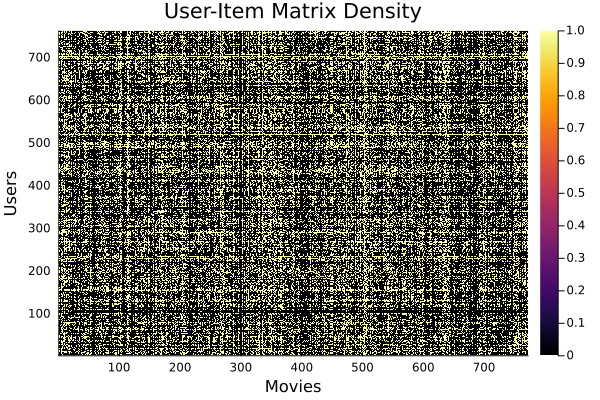

In [271]:
using Plots

# Create a user-item matrix (initialize with NaN for missing values)
num_users = length(train_users)
num_movies = length(popular_movies)
user_item_matrix2 = fill(NaN, num_users, num_movies)
train_users_arr=collect(train_users)
popular_movies_arr=collect(popular_movies)

# Fill in the matrix with ratings from dense_ratings
for row in eachrow(dense_ratings)
    user_idx = findfirst(==(row.userId), train_users_arr)
    movie_idx = findfirst(==(row.movieId), popular_movies_arr)
    if !isnothing(user_idx) && !isnothing(movie_idx)
        user_item_matrix2[user_idx, movie_idx] = row.rating
    end
end

# Visualize the density of the matrix
heatmap(isnan.(user_item_matrix2), title="User-Item Matrix Density", xlabel="Movies", ylabel="Users")

In [52]:

row=first(dense_ratings)
a=row.userId
user_idx = findfirst(==(a), collect(active_users))

206

In [59]:
using DataFrames, CSV, Statistics

# Create mappings from user/movie IDs to matrix indices
user_to_idx = Dict(user => i for (i, user) in enumerate(active_users_arr))
movie_to_idx = Dict(movie => i for (i, movie) in enumerate(popular_movies_arr))

# Initialize the user-item matrix with missing values (NaN)
user_item_matrix = fill(NaN, length(unique_users), length(unique_movies))

# Fill in the matrix with ratings from the data
for row in eachrow(dense_ratings)
    user_idx = user_to_idx[row.userId]
    movie_idx = movie_to_idx[row.movieId]
    user_item_matrix[user_idx, movie_idx] = row.rating
end

# Replace missing values with user averages
for user_idx in 1:length(unique_users)
    # Get the user's ratings, ignoring NaN values
    user_ratings = user_item_matrix[user_idx, :]
    valid_ratings = filter(!isnan, user_ratings)

    # Compute the user's average rating
    if !isempty(valid_ratings)
        user_average = mean(valid_ratings)
        # Replace NaN values with the user's average
        user_item_matrix[user_idx, isnan.(user_ratings)] .= user_average
    end
end

# The user_item_matrix now has missing values replaced with user averages

In [67]:
user_item_matrix
using LinearAlgebra

# Perform SVD decomposition
U, S, Vt = svd(user_item_matrix)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
659×659 Matrix{Float64}:
 0.0346595   0.000121681  -0.114866    …   1.4686e-15   -2.5475e-18
 0.0408467  -0.0713576    -0.0500368       5.91827e-16  -2.04897e-16
 0.0463518  -0.0164154    -0.0212587       5.14964e-15   4.03434e-17
 0.0391697   0.0420753     0.02496         3.01224e-16  -1.37197e-16
 0.040657   -0.00300172   -0.022703       -2.46189e-15   1.92026e-16
 0.0390167  -0.036032     -0.0347755   …   4.75925e-15   3.06709e-16
 0.0372944  -0.075673      0.00562602      1.00192e-15  -6.51263e-17
 0.0385605  -0.00139225    0.0840548      -7.52576e-16   1.70767e-16
 0.0323729   0.114372      0.0232553       5.07028e-16   1.60294e-17
 0.0418164   0.0272301    -0.0197542      -2.80666e-15  -2.59927e-16
 ⋮                                     ⋱                
 0.0387536   0.0252157    -0.0141548   …   8.18242e-16  -5.99498e-18
 0.0384588   0.000869808  -0.0206127       2.43714e-15   1.4856e-16
 0.0368069  -0.0298471    

In [72]:
Vt

772×659 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0333972   0.0490139    0.02934     …  -0.471141    -0.0124088
 0.0326643   0.0286126   -0.0109116       0.0347784    0.0776222
 0.0393787  -0.0556575    0.0283421      -0.0292194    0.0272566
 0.0443521  -0.0649091    0.0207023       0.0225737   -0.0646245
 0.0345693   0.00877901   0.00546484      0.0135968   -0.060837
 0.0367768  -0.00521514  -0.0619988   …   0.00836507   0.00727787
 0.0301828   0.0379432   -0.0533588       0.0148269    0.0189689
 0.0309359   0.0592718   -0.0154473       0.029516     0.0176891
 0.0384981  -0.0711642   -0.0170918       0.0105584    0.0174644
 0.0341904   0.0145734   -0.0194498       0.012969     0.0518091
 ⋮                                    ⋱               
 0.0368962  -0.0652915   -0.035587        0.00153555   0.0258217
 0.035392    0.0259175   -0.0308482       0.0137528    0.0166271
 0.0357324   1.25038e-5  -0.00140385  …   0.0223426   -0.0216573
 0.0329245   0.0502978   -0.0306853      -0.

In [149]:
k = 2  # Number of latent features to retain

2

In [150]:
U_k = U[:, 1:k]          # User feature matrix (m x k)
S_k = Diagonal(S[1:k])   # Top k singular values as a diagonal matrix (k x k)
Vt_k = Vt[:, 1:k]        # Movie feature matrix (k x n)

772×2 Matrix{Float64}:
 0.0333972   0.0490139
 0.0326643   0.0286126
 0.0393787  -0.0556575
 0.0443521  -0.0649091
 0.0345693   0.00877901
 0.0367768  -0.00521514
 0.0301828   0.0379432
 0.0309359   0.0592718
 0.0384981  -0.0711642
 0.0341904   0.0145734
 ⋮          
 0.0368962  -0.0652915
 0.035392    0.0259175
 0.0357324   1.25038e-5
 0.0329245   0.0502978
 0.0377149  -0.0391232
 0.0409438  -0.0158224
 0.031852    0.0330378
 0.0364472  -0.00841686
 0.0346108  -0.0160861

In [151]:
U_k

659×2 Matrix{Float64}:
 0.0346595   0.000121681
 0.0408467  -0.0713576
 0.0463518  -0.0164154
 0.0391697   0.0420753
 0.040657   -0.00300172
 0.0390167  -0.036032
 0.0372944  -0.075673
 0.0385605  -0.00139225
 0.0323729   0.114372
 0.0418164   0.0272301
 ⋮          
 0.0387536   0.0252157
 0.0384588   0.000869808
 0.0368069  -0.0298471
 0.0399219  -0.00909969
 0.0401093   0.0651448
 0.0425093   0.0137241
 0.0300383   0.0275341
 0.0411845  -0.0202264
 0.0375455   0.0402427

In [152]:
user_item_matrix_approx = U_k * S_k * transpose(Vt_k)

659×772 Matrix{Float64}:
 2.86593  2.80272  3.37737  3.80388  …  3.51229  2.73311  3.12665  2.96898
 2.90726  3.02851  4.51432  5.10573     4.2911   2.90401  3.76556  3.65333
 3.72371  3.68456  4.64055  5.23152     4.73236  3.58162  4.20015  4.00634
 3.51472  3.32847  3.50364  3.93359     3.8803   3.2747   3.48615  3.2648
 3.34118  3.27564  3.98529  4.4895      4.12674  3.19211  3.67124  3.48952
 2.98833  3.0162   4.07211  4.59714  …  4.03064  2.91635  3.56057  3.4203
 2.58523  2.72474  4.20031  4.75335     3.94026  2.60482  3.44997  3.35833
 3.17845  3.11231  3.76891  4.24532     3.91085  3.03396  3.48029  3.30644
 3.42838  3.05653  2.30118  2.5577      3.03798  3.05936  2.79133  2.52647
 3.63587  3.48546  3.8725   4.35345     4.18005  3.41756  3.74169  3.52359
 ⋮                                   ⋱                    ⋮        
 3.36943  3.23009  3.58901  4.03476  …  3.87392  3.16715  3.46766  3.26555
 3.18492  3.11277  3.74211  4.21445     3.89574  3.03597  3.46856  3.29284
 2.84634 

In [154]:
err1=sqrt(mean((user_item_matrix- user_item_matrix_approx).^2))

minimum(user_item_matrix)
rating_average=mean(user_item_matrix)
rating_std=std(user_item_matrix)
random_rating=rating_average+rating_std*randn()
random_rating_matrix = rating_average .+ rating_std .* randn(size(user_item_matrix))
err2=sqrt(mean((user_item_matrix- random_rating_matrix).^2))
println("RMSE of SVD: $err1")
println("RMSE of Random: $err2")


RMSE of SVD: 0.6896940269205464
RMSE of Random: 1.2523678945194514


In [155]:
U_k_test=U_k[2:end,:]

658×2 Matrix{Float64}:
 0.0408467  -0.0713576
 0.0463518  -0.0164154
 0.0391697   0.0420753
 0.040657   -0.00300172
 0.0390167  -0.036032
 0.0372944  -0.075673
 0.0385605  -0.00139225
 0.0323729   0.114372
 0.0418164   0.0272301
 0.0399581  -0.030507
 ⋮          
 0.0387536   0.0252157
 0.0384588   0.000869808
 0.0368069  -0.0298471
 0.0399219  -0.00909969
 0.0401093   0.0651448
 0.0425093   0.0137241
 0.0300383   0.0275341
 0.0411845  -0.0202264
 0.0375455   0.0402427

In [156]:
U_k_test = U_k[2:end, :]  # Remaining user feature vectors
U_k_first_user = U_k[1, :]  # Feature vector of the first user

2-element Vector{Float64}:
 0.034659451378434875
 0.00012168120647041406

In [97]:
using Pkg
Pkg.add("Clustering")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed NearestNeighbors ─ v0.4.21
   Installed Distances ──────── v0.10.12
   Installed Clustering ─────── v0.15.7
    Updating `~/.julia/environments/v1.11/Project.toml`
  [aaaa29a8] + Clustering v0.15.7
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [aaaa29a8] + Clustering v0.15.7
  [b4f34e82] + Distances v0.10.12
  [b8a86587] + NearestNeighbors v0.4.21
Precompiling project...
    977.5 ms  ✓ Distances
    657.3 ms  ✓ Distances → DistancesSparseArraysExt
   1394.1 ms  ✓ NearestNeighbors
   1498.2 ms  ✓ Clustering
  4 dependencies successfully precompiled in 6 seconds. 236 already precompiled.


Cluster Centers:
[0.037117302415340246 0.039689006749356624 0.026977940154131134 0.03744550651744982 0.04029295706548137 0.03664980510875724 0.038946612187584634 0.040898154163215 0.034070373218106985 0.03776933729711221; -0.042170651970569024 0.028098153380987315 0.011694660665927586 0.09080758495474872 0.050231266365273385 -0.07098578216998822 -0.005411937501028341 0.010933503403059121 -0.14738689663972848 -0.02334519858955883]


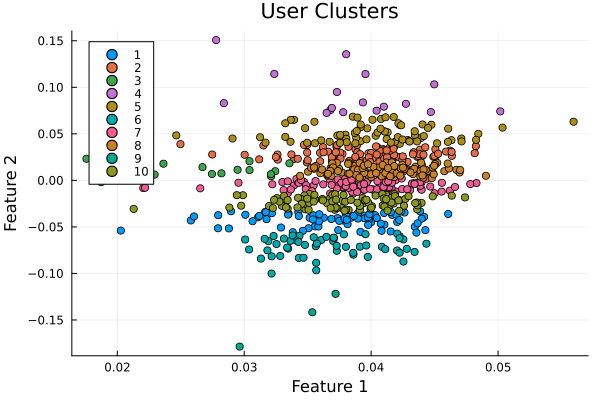

In [247]:
using Clustering

# Assuming U_k_test is the user feature matrix without the first user's features
# U_k_test has dimensions (num_users - 1) x k, where k is the number of latent features

# Set the number of clusters
num_clusters = 10# You can experiment with different values

# Perform K-means clustering
kmeans_result = kmeans(transpose(U_k_test), num_clusters)

# Extract the cluster assignments for each user
cluster_assignments = kmeans_result.assignments

# Print the cluster centers
println("Cluster Centers:")
println(kmeans_result.centers)
scatter(U_k_test[:, 1], U_k_test[:, 2], group=cluster_assignments, xlabel="Feature 1", ylabel="Feature 2", title="User Clusters")

In [248]:
kmeans_result.centers

2×10 Matrix{Float64}:
  0.0371173  0.039689   0.0269779  …  0.0408982   0.0340704   0.0377693
 -0.0421707  0.0280982  0.0116947     0.0109335  -0.147387   -0.0233452

In [191]:
using Pkg
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [249]:
function pick_next_movie_from_vector(user_id, user_item_matrix, movie_to_idx,U_cluster,S_k, Vt_k)
    # Get the user's feature vector
    user_idx = user_to_idx[user_id]
    user_features = U_k[user_idx, :]

    # Compute the predicted ratings for all movies
    all_ratings = (transpose(U_cluster)*S_k) * transpose(Vt_k)

    # Find the indices of the top recommendations
    sorted_indices = sortperm(all_ratings, rev=true)
    top_indices = filter(idx -> isnan(user_item_matrix[user_idx, idx]), sorted_indices)

    # Pick the top movies that the user hasn't seen yet
    return recommendations
end



pick_next_movie_from_vector (generic function with 1 method)

In [250]:
using Distributions
# Create a non-informative prior (all elements set to 1)
alpha = ones(num_clusters)

# Create the Dirichlet distribution with the specified alpha
dirichlet_prior = Dirichlet(alpha)

println("Dirichlet prior: ", dirichlet_prior)

Dirichlet prior: Dirichlet{Float64, Vector{Float64}, Float64}(
alpha: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)



In [251]:
sample_prior = rand(dirichlet_prior)
println("Sample from Dirichlet prior: ", sample_prior)
# Create a Categorical distribution with the given probabilities
categorical_dist = Categorical(sample_prior)

# Sample a cluster (this will return an integer between 1 and the number of clusters)
sampled_cluster = rand(categorical_dist)

sampled_vector=kmeans_result.centers[:,sampled_cluster]

#randomly pick a movie out of the ones that the first user has seen
first_user_ratings=user_item_matrix2[1,:]

all_ratings = (transpose(sampled_vector)*S_k) * transpose(Vt_k)
#sorted_indices = sortperm(all_ratings, rev=true)
#top_indices = filter(idx -> isnan(user_item_matrix[user_idx, idx]), sorted_indices)

# Pick an index with a non-NaN rating for the first user
valid_movie_indices = findall(!isnan, first_user_ratings)

random_movie_index = rand(valid_movie_indices)

forecast_rating = dot(S_k*U_k_first_user, Vt_k[random_movie_index, :])

U_k_first_user
print("Forecasted rating: $forecast_rating")
#Vt_k[random_movie_index, :]
(transpose(kmeans_result.centers)*S_k)*Vt_k[random_movie_index, :]
#cluster_forecasts=dot(kmeans_result.centers*S_k, Vt_k[random_movie_index, :])

Sample from Dirichlet prior: [0.1169158586083647, 0.016198966891448355, 0.043555477765035884, 0.015232088137772165, 0.1596564322364934, 0.4006206512039099, 0.02296113461729002, 0.14356726929640048, 0.04451896381743303, 0.03677315742585198]
Forecasted rating: 3.2118140411580605

10-element Vector{Float64}:
 3.535422823614675
 3.6145428403797744
 2.4737024559958583
 3.264538262083397
 3.6203653279830204
 3.557386283061066
 3.6216678052034874
 3.765492990302865
 3.4914446504310472
 3.5531960540248284

In [252]:

function pick_next_movie(all_ratings,user_item_matrix2,movies_rated)
    sorted_indeces=sortperm(all_ratings, rev=true, dims=2)
    i=1
    while isnan(user_item_matrix2[1,sorted_indeces[1,i]])||(sorted_indeces[1,i] in movies_rated)
        i+=1
    end
    return sorted_indeces[1,i]
end
movies_rated=[]
#sorted_indeces=sortperm(all_ratings, rev=true, dims=2)
#i=1
##while isnan(user_item_matrix2[1,sorted_indeces[1,i]])||(sorted_indeces[1,i] in movies_rated)
#    i+=1
#end
i=pick_next_movie(all_ratings,user_item_matrix2,movies_rated)

353

Predicted rating: 2.927536994059298
Actual rating: 4.0
Loss: 1.1501768991113663
Predicted rating: 4.394593980307023
Actual rating: 2.0
Loss: 5.734080330522629
Predicted rating: 2.8707163750139384
Actual rating: 3.0
Loss: 0.016714255689536613
Predicted rating: 4.2675999569572385
Actual rating: 4.5
Loss: 0.0540097800062774
Predicted rating: 2.837277156566468
Actual rating: 4.0
Loss: 1.3519244106421575
Predicted rating: 4.199360824510677
Actual rating: 4.0
Loss: 0.03974473834957697
Predicted rating: 5.488978739239337
Actual rating: 4.5
Loss: 0.9780789466674281
Predicted rating: 4.185615282257701
Actual rating: 5.0
Loss: 0.6632224684922039
Predicted rating: 2.831784473639079
Actual rating: 3.0
Loss: 0.028296463308881734
Predicted rating: 4.16187290383744
Actual rating: 4.5
Loss: 0.11432993315932494
Predicted rating: 5.373877137048142
Actual rating: 4.0
Loss: 1.887538387703599
Predicted rating: 4.2573140671532235
Actual rating: 2.0
Loss: 5.095466797767828
Predicted rating: 4.25372691074354


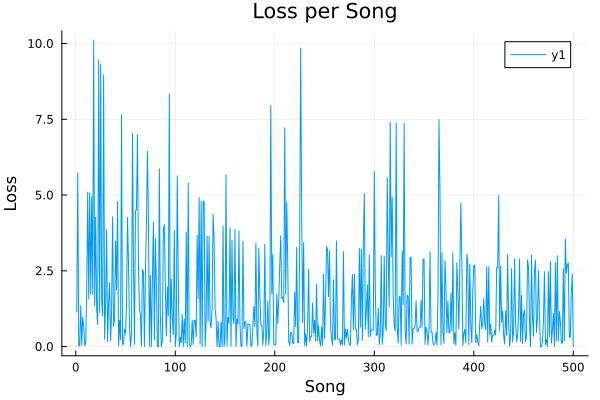

In [253]:
using Distributions
movies_rated=[]
loss_history=[]

# Create a non-informative prior (all elements set to 1)
alpha = ones(num_clusters)
counts=zeros(num_clusters)

# Create the Dirichlet distribution with the specified alpha
dirichlet_prior = Dirichlet(alpha+counts)

num_songs=500
for i in 1:num_songs
    # Sample a cluster
    dirichlet_prior = Dirichlet(alpha+counts)
    sample_prior = rand(dirichlet_prior)
    categorical_dist = Categorical(sample_prior)
    sampled_cluster = rand(categorical_dist)
    #counts[sampled_cluster]+=1
    sampled_vector=kmeans_result.centers[:,sampled_cluster]
    all_ratings = (transpose(sampled_vector)*S_k) * transpose(Vt_k)
    next_movie=pick_next_movie(all_ratings,user_item_matrix2,movies_rated)
    push!(movies_rated,next_movie)
    all_cluster_ratings=(transpose(kmeans_result.centers)*S_k)*Vt_k[next_movie, :]
    max_cluster=argmax(all_cluster_ratings)
    counts[max_cluster]+=1
    actual_rating=user_item_matrix2[1,next_movie]
    println("Predicted rating: ", all_ratings[1,next_movie])
    println("Actual rating: ", actual_rating)
    loss=(all_ratings[1,next_movie]-actual_rating)^2
    println("Loss: ", loss)
    push!(loss_history,loss)
end
print(counts)
plot(loss_history, xlabel="Song", ylabel="Loss", title="Loss per Song")